# Baseline_2nd: Simple baseline for ASHRAE Dataset
`@Author: YUAN Yanzhe`  
The 2nd iteration    
Little feature engineering, refered to `ASHRAE_Sample3`, just go through the standard data analysis process

Output: ashrae_rf_featured_1/2/3.csv

Scores: 
- Tried building_id, meter, site_id, primary, suare_feet, airtemp, dewtemp, sea_level, min_speed features with little feature enginerring, the reuslt is 1.341 public. The model is random forest with 20 estimators, random_state=11.
- Tried all attributes with the same feature engineering, the result is：1.336. The model training started from 10:49 to 12：30 .
- Tried all attributes with the same feature engineering. The model is random forest with 50 estimators, random_state=12. Scores: 1.323

In [2]:
# Importing required libraries

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from pytz import timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from bokeh.layouts import row
from bokeh.io import show, output_file
from bokeh.plotting import figure
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [3]:
#let's load datasets

train_df = pd.read_csv("ashrae-energy-prediction/train.csv")
building_df = pd.read_csv("ashrae-energy-prediction/building_metadata.csv")
test_df = pd.read_csv("ashrae-energy-prediction/test.csv")
weather_train_df = pd.read_csv('ashrae-energy-prediction/weather_train.csv')
weather_test_df = pd.read_csv('ashrae-energy-prediction/weather_test.csv')

##### FE: change the datetime

In [4]:
# Data preprocessing for training data:

train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
train_df['datetime'] = train_df['timestamp'].astype('datetime64[ns]') 
train_df['date'] = train_df['datetime'].apply(datetime.date)
train_df['time'] = train_df['datetime'].apply(datetime.time)
train_df.head()

,building_id,meter,timestamp,meter_reading,datetime,date,time
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00


In [6]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [7]:
test_df['datetime'] = test_df['timestamp'].astype('datetime64[ns]') 
test_df['date'] = test_df['datetime'].apply(datetime.date)
test_df['time'] = test_df['datetime'].apply(datetime.time)
test_df.head()

,row_id,building_id,meter,timestamp,datetime,date,time
0,0,0,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00
1,1,1,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00
2,2,2,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00
3,3,3,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00
4,4,4,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00


##### FE: Drop unecessary columns

In [8]:
# Data preprocessing for building data:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [9]:
nan_cnt = building_df.isna().sum()
nan_cnt

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [10]:
building_df = building_df.drop(columns='floor_count')
building_df = building_df.drop(columns='year_built')

##### Merge

In [11]:
# Merge train/test with building:

train_building_df = pd.merge(train_df, building_df, on = "building_id", how = "left")
test_building_df = pd.merge(test_df, building_df, on = "building_id", how = "left")

In [12]:
train_building_df.head()

,building_id,meter,timestamp,meter_reading,datetime,date,time,site_id,primary_use,square_feet
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,7432
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,2720
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,5376
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,23685
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,116607


In [13]:
test_building_df.head()

,row_id,building_id,meter,timestamp,datetime,date,time,site_id,primary_use,square_feet
0,0,0,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,7432
1,1,1,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,2720
2,2,2,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,5376
3,3,3,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,23685
4,4,4,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,116607


##### FE: fill nan value with median value

In [14]:
# Data preprocessing for weather data:

weather_nan_train = weather_train_df.isna().sum()
print(weather_nan_train)
weather_nan_test = weather_test_df.isna().sum()
print(weather_nan_test)

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64
site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64


In [15]:
weather_train_df['timestamp_2'] = weather_train_df['timestamp'].astype(str).str[:-6]
weather_train_df['timestamp_2'] = pd.to_datetime(weather_train_df['timestamp_2'])
weather_train_df['date'] = weather_train_df['timestamp_2'].apply(datetime.date)
weather_train_df['time'] = weather_train_df['timestamp_2'].apply(datetime.time)

weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2,date,time
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01 00:00:00,2016-01-01,00:00:00
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,2016-01-01 01:00:00,2016-01-01,01:00:00
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,2016-01-01 02:00:00,2016-01-01,02:00:00
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,2016-01-01 03:00:00,2016-01-01,03:00:00
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,2016-01-01 04:00:00,2016-01-01,04:00:00


In [16]:
weather_train_df['air_temperature'] = weather_train_df['air_temperature'].fillna(weather_train_df.groupby('date')['air_temperature'].transform('median'))
weather_train_df['dew_temperature'] = weather_train_df['dew_temperature'].fillna(weather_train_df.groupby('date')['dew_temperature'].transform('median'))
weather_train_df['sea_level_pressure'] = weather_train_df['sea_level_pressure'].fillna(weather_train_df.groupby('date')['sea_level_pressure'].transform('median'))
weather_train_df['wind_speed'] = weather_train_df['wind_speed'].fillna(weather_train_df.groupby('date')['wind_speed'].transform('median'))
weather_train_df['cloud_coverage'] = weather_train_df['cloud_coverage'].fillna(weather_train_df.groupby('date')['cloud_coverage'].transform('median'))
weather_train_df['precip_depth_1_hr'] = weather_train_df['precip_depth_1_hr'].fillna(weather_train_df.groupby('date')['precip_depth_1_hr'].transform('median'))
weather_train_df['wind_direction'] = weather_train_df['wind_direction'].fillna(weather_train_df.groupby('date')['wind_direction'].transform('median'))

In [17]:
weather_test_df['timestamp_2'] = weather_test_df['timestamp'].astype(str).str[:-6]
weather_test_df['timestamp_2'] = pd.to_datetime(weather_test_df['timestamp_2'])
weather_test_df['date'] = weather_test_df['timestamp_2'].apply(datetime.date)
weather_test_df['time'] = weather_test_df['timestamp_2'].apply(datetime.time)

weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2,date,time
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,2017-01-01 00:00:00,2017-01-01,00:00:00
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1,2017-01-01 01:00:00,2017-01-01,01:00:00
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1,2017-01-01 02:00:00,2017-01-01,02:00:00
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1,2017-01-01 03:00:00,2017-01-01,03:00:00
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6,2017-01-01 04:00:00,2017-01-01,04:00:00


In [18]:
weather_test_df['air_temperature'] = weather_test_df['air_temperature'].fillna(weather_test_df.groupby('date')['air_temperature'].transform('median'))
weather_test_df['dew_temperature'] = weather_test_df['dew_temperature'].fillna(weather_test_df.groupby('date')['dew_temperature'].transform('median'))
weather_test_df['sea_level_pressure'] = weather_test_df['sea_level_pressure'].fillna(weather_test_df.groupby('date')['sea_level_pressure'].transform('median'))
weather_test_df['wind_speed'] = weather_test_df['wind_speed'].fillna(weather_test_df.groupby('date')['wind_speed'].transform('median'))
weather_test_df['cloud_coverage'] = weather_test_df['cloud_coverage'].fillna(weather_test_df.groupby('date')['cloud_coverage'].transform('median'))
weather_test_df['precip_depth_1_hr'] = weather_test_df['precip_depth_1_hr'].fillna(weather_test_df.groupby('date')['precip_depth_1_hr'].transform('median'))
weather_test_df['wind_direction'] = weather_test_df['wind_direction'].fillna(weather_test_df.groupby('date')['wind_direction'].transform('median'))

##### Merge

In [33]:
# Merge train/test with building with weather data

merge_df = train_building_df.merge(weather_train_df, on=['site_id', 'date', 'time'], how='left')
merge_df.head()

,building_id,meter,timestamp_x,meter_reading,datetime,date,time,site_id,primary_use,square_feet,timestamp_y,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,7432,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,2016-01-01
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,2720,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,2016-01-01
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,5376,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,2016-01-01
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,23685,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,2016-01-01
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,116607,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,2016-01-01


In [34]:
merge_df = merge_df.drop(columns="timestamp_x")
merge_df = merge_df.drop(columns="timestamp_y")
merge_df = merge_df.drop(columns="timestamp_2")

In [35]:
merge_df.shape

(20216100, 16)

In [36]:
merge_df_test = test_building_df.merge(weather_test_df, on=['site_id', 'date', 'time'], how='left')
merge_df_test.head()

,row_id,building_id,meter,timestamp_x,datetime,date,time,site_id,primary_use,square_feet,timestamp_y,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2
0,0,0,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,7432,2017-01-01 00:00:00,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,2017-01-01
1,1,1,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,2720,2017-01-01 00:00:00,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,2017-01-01
2,2,2,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,5376,2017-01-01 00:00:00,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,2017-01-01
3,3,3,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,23685,2017-01-01 00:00:00,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,2017-01-01
4,4,4,0,2017-01-01 00:00:00,2017-01-01,2017-01-01,00:00:00,0,Education,116607,2017-01-01 00:00:00,17.8,4.0,11.7,0.0,1021.4,100.0,3.6,2017-01-01


In [37]:
merge_df_test = merge_df_test.drop(columns="timestamp_x")
merge_df_test = merge_df_test.drop(columns="timestamp_y")
merge_df_test = merge_df_test.drop(columns="timestamp_2")

In [38]:
merge_df_test.shape

(41697600, 16)

##### Visualization for correlations

In [39]:
# Draw a correlation check
corr_matrix_train = merge_df.corr()
corr_matrix_train

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
building_id,1.000000,0.222268,0.008761,0.980975,0.087704,-0.314100,-0.146677,-0.110042,0.013942,0.074686,0.049508,0.003531
meter,0.222268,1.000000,0.017672,0.253875,0.132708,-0.011158,-0.121693,-0.080436,0.000306,-0.053352,-0.019516,-0.081129
meter_reading,0.008761,0.017672,1.000000,0.011897,0.024308,-0.004132,0.003049,-0.003331,0.000766,-0.004225,-0.000218,0.006074
site_id,0.980975,0.253875,0.011897,1.000000,0.090934,-0.307133,-0.127506,-0.135113,0.014682,0.052499,0.049718,0.011420
square_feet,0.087704,0.132708,0.024308,0.090934,1.000000,-0.015684,-0.034562,-0.023453,0.003903,-0.021577,-0.008167,-0.034895
air_temperature,-0.314100,-0.011158,-0.004132,-0.307133,-0.015684,1.000000,0.081316,0.750637,0.005450,-0.314474,-0.082452,-0.081802
cloud_coverage,-0.146677,-0.121693,0.003049,-0.127506,-0.034562,0.081316,1.000000,0.119144,0.021005,-0.087255,0.014350,0.132691
dew_temperature,-0.110042,-0.080436,-0.003331,-0.135113,-0.023453,0.750637,0.119144,1.000000,0.069197,-0.219831,-0.158102,-0.141810
precip_depth_1_hr,0.013942,0.000306,0.000766,0.014682,0.003903,0.005450,0.021005,0.069197,1.000000,-0.054495,-0.012107,0.025861
sea_level_pressure,0.074686,-0.053352,-0.004225,0.052499,-0.021577,-0.314474,-0.087255,-0.219831,-0.054495,1.000000,-0.093751,-0.194523


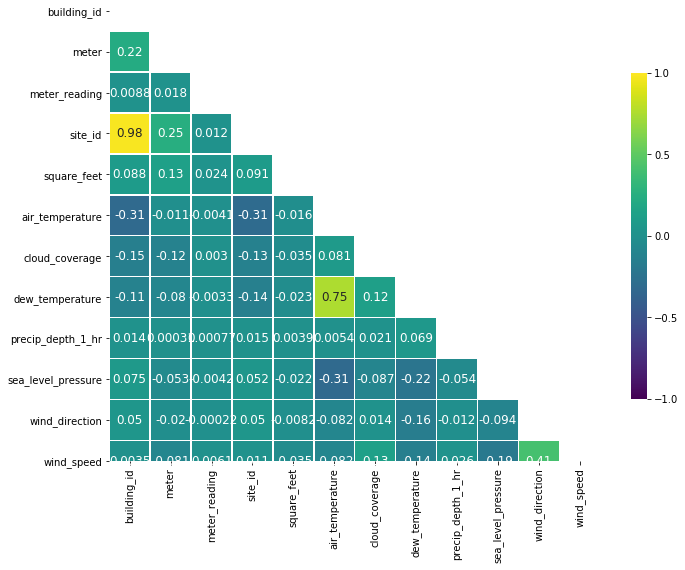

In [40]:
import seaborn as sns
mask = np.zeros_like(corr_matrix_train, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix_train, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix_train.columns, rotation = 0)
ax.set_xticklabels(corr_matrix_train.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

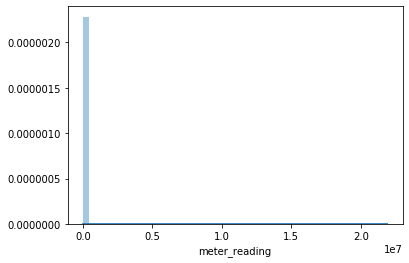

In [41]:
sns.distplot(merge_df['meter_reading'])
plt.show()

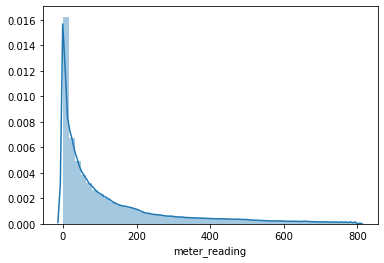

In [42]:
# Filter the outliers

merge_df_1 = merge_df[merge_df['meter_reading']<=800]
sns.distplot(merge_df_1['meter_reading'])
plt.show()

In [43]:
merge_df_1.shape

(18189116, 16)

In [44]:
merge_df.shape

(20216100, 16)

##### FE: text encoding for text data

In [47]:
# Data preprocessing for text data:

# Deal with text information, transform into numbers.
# Applying label encoding technique on "primary_use" column as it contains categorical text data

# preprocessing means create a encoder
# fit means create a standard creteria of the input parameters i.e. fit(y), use transform later to encode following the rules of y
# transform returns an encoding value.
# fit_transform

label_encoder = preprocessing.LabelEncoder()

merge_df["primary_use"] = label_encoder.fit_transform(merge_df["primary_use"])
merge_df_test["primary_use"] = label_encoder.transform(merge_df_test["primary_use"]) # 用了一次fit了，后面直接用之前的标准


# Normalizing the dataset because "square_feet" is in different scale than other columns 

# standard_scaler = preprocessing.StandardScaler().fit(merge_df)

# merge_df = standard_scaler.transform(merge_df)
# merge_df_test = standard_scaler.transform(merge_df_test)

In [48]:
merge_df.shape

(20216100, 16)

In [49]:
merge_df.head()

,building_id,meter,meter_reading,datetime,date,time,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0.0,2016-01-01,2016-01-01,00:00:00,0,0,7432,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1,0,0.0,2016-01-01,2016-01-01,00:00:00,0,0,2720,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2,0,0.0,2016-01-01,2016-01-01,00:00:00,0,0,5376,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
3,3,0,0.0,2016-01-01,2016-01-01,00:00:00,0,0,23685,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
4,4,0,0.0,2016-01-01,2016-01-01,00:00:00,0,0,116607,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [50]:
merge_df_test.head()

,row_id,building_id,meter,datetime,date,time,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,2017-01-01,00:00:00,0,0,7432,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
1,1,1,0,2017-01-01,2017-01-01,00:00:00,0,0,2720,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
2,2,2,0,2017-01-01,2017-01-01,00:00:00,0,0,5376,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
3,3,3,0,2017-01-01,2017-01-01,00:00:00,0,0,23685,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
4,4,4,0,2017-01-01,2017-01-01,00:00:00,0,0,116607,17.8,4.0,11.7,0.0,1021.4,100.0,3.6


In [51]:
type(merge_df)

pandas.core.frame.DataFrame

##### FE: Extract Features and make train and test data

In [88]:
# Split train data and train label

features_remained = ['building_id','meter', 'site_id','primary_use','square_feet','air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
x_test = merge_df_test[features_remained]
y_train = merge_df[['meter_reading']]
x_train = merge_df[features_remained]

In [89]:
x_test.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,7432,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
1,1,0,0,0,2720,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
2,2,0,0,0,5376,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
3,3,0,0,0,23685,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
4,4,0,0,0,116607,17.8,4.0,11.7,0.0,1021.4,100.0,3.6


In [90]:
x_train.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,7432,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1,0,0,0,2720,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2,0,0,0,5376,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
3,3,0,0,0,23685,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
4,4,0,0,0,116607,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [91]:
y_train.head()

,meter_reading
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [92]:
print(x_test.shape, x_train.shape, y_train.shape)

(41697600, 12) (20216100, 12) (20216100, 1)


In [93]:
# deal with na value
print(x_train.isna().sum())
print(x_test.isna().sum())

building_id               0
meter                     0
site_id                   0
primary_use               0
square_feet               0
air_temperature       90495
cloud_coverage        90495
dew_temperature       90495
precip_depth_1_hr     90495
sea_level_pressure    90495
wind_direction        90495
wind_speed            90495
dtype: int64
building_id                0
meter                      0
site_id                    0
primary_use                0
square_feet                0
air_temperature       199029
cloud_coverage        301557
dew_temperature       199029
precip_depth_1_hr     199029
sea_level_pressure    199029
wind_direction        199029
wind_speed            199029
dtype: int64


##### FE: We can choose to use inner join to train data, but can't do that to test data because it will lose data. So I simply fill na with 0 value for all train and test data

In [94]:
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)
print(x_train.isna().sum())
print(x_test.isna().sum())

building_id           0
meter                 0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64
building_id           0
meter                 0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64


### Model

In [97]:
%time
# Train a model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=12)
model.fit(x_train.values, y_train.values)

y_prediction = model.predict(x_test.values)



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 22.9 µs


In [98]:
# Make a submission

submission = pd.DataFrame({'row_id':merge_df_test['row_id'], 'meter_reading':y_prediction})

submission.to_csv("ashrae_rf_featured_3.csv",index=False)

In [87]:
y_prediction.shape

(41697600,)

##### Results:
- Tried building_id, meter, site_id, primary, suare_feet, airtemp, dewtemp, sea_level, min_speed features with little feature enginerring, the reuslt is 1.341 private. The model is random forest with 20 estimators, random_state=11.
- Tried all attributes with the same feature engineering, the result is：. The model training started from 10:49 to 12：30 .
- Tried all attributes with the same feature engineering. The model is random forest with 50 estimators, random_state=12. 1:28 to :

In [67]:
# Joining required dataset in single dataframe

df_train_building_left = pd.merge(train_df, bilding_df, on = "building_id", how = "left")
df_test_building_left = pd.merge(test_df, bilding_df, on = "building_id", how = "left")

In [68]:
df_train_building_left.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


In [69]:
# find the columns that contains null values
for column in df_train_building_left:
    print(column + "\t" + str(df_train_building_left[column].isnull().any()))

building_id	False
meter	False
timestamp	False
meter_reading	False
site_id	False
primary_use	False
square_feet	False
year_built	True
floor_count	True


In [70]:
# converting data into training and testing part
# give up columns that contains null values and give up the timestamp
X_train, X_test, y_train, y_test = train_test_split(df_train_building_left[["building_id", "meter", "site_id", "primary_use", "square_feet"]], df_train_building_left["meter_reading"], test_size = 0.25)

In [71]:
df_train_building_left.shape

(20216100, 9)

#### Data Preprocessing


In [72]:
# Deal with text information, transform into numbers.
# Applying label encoding technique on "primary_use" column as it contains categorical text data

# preprocessing means create a encoder
# fit means create a standard creteria of the input parameters i.e. fit(y), use transform later to encode following the rules of y
# transform returns an encoding value.
# fit_transform

label_encoder = preprocessing.LabelEncoder()

X_train["primary_use"] = label_encoder.fit_transform(X_train["primary_use"])
X_test["primary_use"] = label_encoder.transform(X_test["primary_use"]) # 用了一次fit了，后面直接用之前的标准


# Normalizing the dataset because "square_feet" is in different scale than other columns 

standard_scaler = preprocessing.StandardScaler().fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

#### Model

In [73]:
# Building a simple random forest regression model on preprocessed data
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, random_state=7)
model.fit(X_train, y_train.values)
y_pred_lr = model.predict(X_test)

# Building a simple linear regression model 

# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train.values)
# y_pred_lr = lin_reg.predict(X_test)

In [74]:
# deal with the outliers

y_pred_lr[y_pred_lr < 0] = 0

In [75]:
# Calculating accuracy

print(np.sqrt(mean_squared_log_error( y_test, y_pred_lr )))

1.6211251193833627


`results:`
- linear regression: 
- gradient boosting with default parameters: 2.58
- random forest with 10 estimators: 1.62

#### Visualization and Submission

In [80]:
from sklearn.ensemble import RandomForestRegressor
%time
label_encoder = preprocessing.LabelEncoder()

df_train_building_left["primary_use"] = label_encoder.fit_transform(df_train_building_left["primary_use"])
df_test_building_left["primary_use"] = label_encoder.transform(df_test_building_left["primary_use"])

final_X_train = df_train_building_left[["building_id", "meter", "site_id", "primary_use", "square_feet"]]
final_X_test = df_test_building_left[["building_id", "meter", "site_id", "primary_use", "square_feet"]]

final_y_train = df_train_building_left["meter_reading"]

standard_scaler = preprocessing.StandardScaler().fit(final_X_train)
final_X_train = standard_scaler.transform(final_X_train)
final_X_test = standard_scaler.transform(final_X_test)

lin_reg = RandomForestRegressor(n_estimators=50, random_state=8)
lin_reg.fit(final_X_train, final_y_train.values)
y_pred_lr = lin_reg.predict(final_X_test)

# label_encoder = preprocessing.LabelEncoder()

# df_train_building_left["primary_use"] = label_encoder.fit_transform(df_train_building_left["primary_use"])
# df_test_building_left["primary_use"] = label_encoder.transform(df_test_building_left["primary_use"])

# final_X_train = df_train_building_left[["building_id", "meter", "site_id", "primary_use", "square_feet"]]
# final_X_test = df_test_building_left[["building_id", "meter", "site_id", "primary_use", "square_feet"]]

# final_y_train = df_train_building_left["meter_reading"]

# standard_scaler = preprocessing.StandardScaler().fit(final_X_train)
# final_X_train = standard_scaler.transform(final_X_train)
# final_X_test = standard_scaler.transform(final_X_test)

# lin_reg = LinearRegression()
# lin_reg.fit(final_X_train, final_y_train.values)
# y_pred_lr = lin_reg.predict(final_X_test)

In [81]:
submission = pd.DataFrame({'row_id':df_test_building_left['row_id'], 'meter_reading':y_pred_lr})

submission.to_csv("ashrae_prediction_random_forest_50.csv",index=False)